# KNN model

### Imports

In [43]:
# Basic Imports
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from matplotlib import pyplot
import yfinance as yf

# Machine Learning Imports
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance
from tabulate import tabulate
from sklearn.model_selection import train_test_split

# ----------------------------------------------------------------------------------------

# Load CSV File 

In [2]:
# From 16.08.2007 to 26.04.2022
bco = pd.read_csv('/Users/romaindeleze/Desktop/BSc/Romain_WI_TZ/8.Semester/BA/Daten/Brent_Crude_Oil')

In [3]:
bco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3641 entries, 0 to 3640
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         3641 non-null   object 
 1   Close        3641 non-null   float64
 2   Log_Returns  3641 non-null   float64
 3   Pred_Signal  3641 non-null   int64  
 4   RSI          3641 non-null   float64
 5   K_percent    3641 non-null   float64
 6   MACD         3641 non-null   float64
 7   ROC          3641 non-null   float64
dtypes: float64(6), int64(1), object(1)
memory usage: 227.7+ KB


In [4]:
bco.head()

,Date,Close,Log_Returns,Pred_Signal,RSI,K_percent,MACD,ROC
0,2007-08-16,69.769997,-0.026449,1,29.797228,9.756045,-0.572856,-0.066622
1,2007-08-17,70.440002,0.009557,0,37.710864,17.926851,-0.563372,-0.010257
2,2007-08-20,69.849998,-0.008411,0,33.868557,11.206854,-0.584877,-0.027159
3,2007-08-21,68.690002,-0.016746,1,27.466358,6.351211,-0.665806,-0.032399
4,2007-08-22,68.699997,0.000145,1,27.604705,6.649574,-0.718980,-0.021507


# ----------------------------------------------------------------------------------------

# Building the K-nearst Neighbors Model
##### We have split our data into a training set and testing set, so we need to identify our input columns which are the following:
##### RSI, Stochastic Oscillator, Price Rate of Change, MACD, Signal
##### Those columns will serve as our X , and our Y column will be the Signal column, the column that specifies whether the future closed up or down compared to the previous day.
##### Once we've selected our columns, we need to split the data into a training and test set. Which will take our features and labels and split them based on the size we input. In our case, let's have the test_size be '20 % . After we've split the data, we can create our KNeighborsClassifier model. Once we've created it, we can fit the training data to the model using the fit method. Finally, with our "trained" model, we can make predictions. Take the X_test data set and use it to make predictions.

### First we have to choose the label and the features we are looking for. Second step is to scale the data because the KNN works with distance. 

In [5]:
# Choose of the features we want in the knn model
features = bco[['RSI','K_percent','ROC','MACD']] 
labels = bco['Pred_Signal']

# We sacale the data with the MinMaxSacaler in values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1)) 
scaled_features = scaler.fit_transform(features)

# Fill features dataset with Scaled Data
features['RSI'] = scaled_features[:,0]
features['K_percent'] = scaled_features[:,1]
features['ROC'] = scaled_features[:,2]
features['MACD'] = scaled_features[:,3]
# The label is allready between 0 and 1

<ipython-input-5-4708a1e9adee>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['RSI'] = scaled_features[:,0]
<ipython-input-5-4708a1e9adee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['K_percent'] = scaled_features[:,1]
<ipython-input-5-4708a1e9adee>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

In [6]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.2, shuffle=False)

# Split the data in a 80%, 20% proportion
print('Features lenght = ',len(features))
print('Label lenght = ',len(labels))
print()
print('X_train lenght = ',len(X_train))
print('y_train lenght = ',len(y_train))
print('X_test lenght = ',len(X_test))
print('y_test lenght = ',len(y_test))

print('Backtesting: ',len(X_train)+len(X_test))
print('Backtesting: ',len(y_train)+len(y_test))

Features lenght =  3641
Label lenght =  3641

X_train lenght =  2912
y_train lenght =  2912
X_test lenght =  729
y_test lenght =  729
Backtesting:  3641
Backtesting:  3641


# ----------------------------------------------------------------------------------------

## Hyperparameter Tuning
#### Lets get first a closer look which parameter exists for knn classification models

In [7]:
#Create KNN Object.
knn = KNeighborsClassifier()

# Look at parameters used by our current KNeighborsClassifier
pprint(knn.get_params())

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}


### With the RandomizedSearchCV command we can achive the hyperparameter tuning 
##### We have to choose which hyperparameter we want tune. Then we have to creat lists with the parameter values for which we are looking for. The GridSearchCV command will compute all combinations and then we can access to the best parameter values.

In [8]:
# List hyperparameters that we want to tune.

# Algorithm used to compute the nearest neighbors
algorithm = ['auto','brute'] # 2 Possibilities

# number of each leaf size
leaf_size = list(range(1,50)) # 500 Possibilities

# Distanz metrics, 1 = Manhattan distanz, 2 = Euclidian distanz
p = [1,2] # 2 Possibilities

# How weighted are the data points 
weights = ['uniform', 'distance'] # 2 Possibilities

# number of neighbors
n_neighbors = list(range(4,50)) # 200 Possibilities


# Create the random grid
random_grid = {'algorithm':algorithm,
               'leaf_size':leaf_size,
               'p':p,
               'weights':weights,
               'n_neighbors':n_neighbors}

#pprint(random_grid)

In [9]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
knn_2 = KNeighborsClassifier()

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
knn_random = RandomizedSearchCV(estimator = knn_2, param_distributions = random_grid, n_iter = 100,
                               cv = 3, verbose = 1, random_state = 8, n_jobs = 1)

# Fit the random search model
knn_random.fit(X_train, y_train) # The optimisation may take a few minutes

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=100, n_jobs=1,
                   param_distributions={'algorithm': ['auto', 'brute'],
                                        'leaf_size': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'n_neighbors': [4, 5, 6, 7, 8, 9, 10,
                                                        11, 12, 13, 14, 15, 16,
                                                        17, 18, 19, 20, 21, 22,
                                                        23, 24, 25, 26, 27, 28,
                                                        29, 30, 31, 32, 33, ...],
                                        'p': [1, 2],
       

In [10]:
# This is the Output command to see the best Parameters 
param = knn_random.best_params_
print(param)

{'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'leaf_size': 15, 'algorithm': 'auto'}


# ----------------------------------------------------------------------------------------

## After the optimisation we can creat the random forest model and make the predictions

In [11]:
# Creat best knn model
best_knn = KNeighborsClassifier(weights = param['weights'], 
                                p = param['p'], 
                                n_neighbors = param['n_neighbors'], 
                                leaf_size = param['leaf_size'], 
                                algorithm = param['algorithm'])

# Fit the model with the training dataset
best_knn.fit(X_train, y_train)

# Predict test data set.
y_pred = best_knn.predict(X_test)

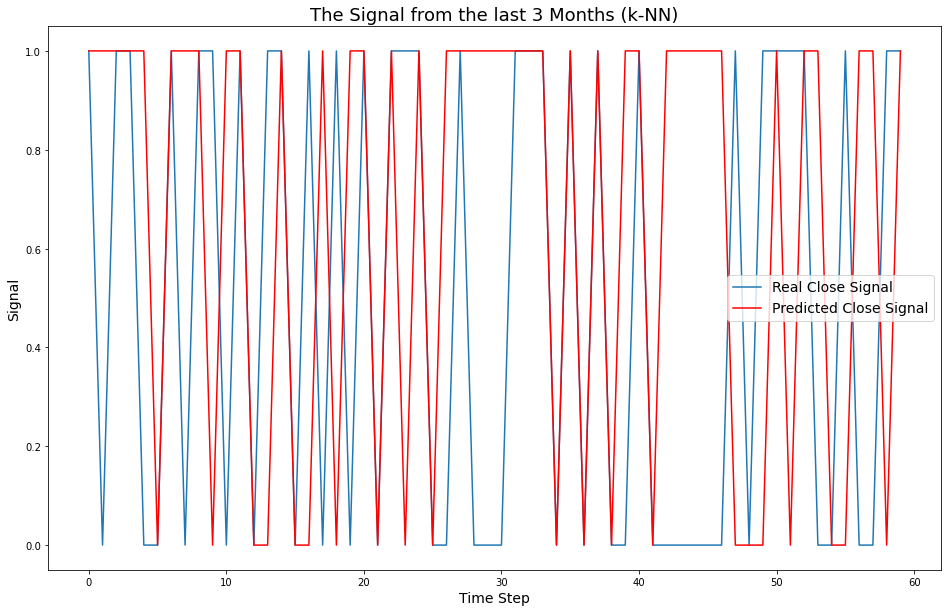

In [12]:
m3 = 3*4*5
plt.figure(figsize=(16,10))
plt.title('The Signal from the last 3 Months (k-NN)', fontsize = 18)
plt.plot(y_test[len(y_test)-m3:].values, label = 'Real Close Signal')
plt.plot(y_pred[len(y_pred)-m3:], color = 'red', label = 'Predicted Close Signal')
plt.ylabel('Signal', fontsize = 14)
plt.xlabel('Time Step', fontsize = 14)
plt.legend(loc='best', fontsize = 14)

# ----------------------------------------------------------------------------------------

# Accuracy
##### We've built our model, so now we can see how accurate it is. SciKit learn, makes the process of evaluating our model very easy by providing a bunch of built-in metrics that we can call. One of those metrics is the accuracy_score. The accuracy_score function computes the accuracy, by calculating the sum of the correctly predicted signals and then dividing it by the total number of predictions. Imagine we had three TRUE values [1, 2, 3] , and our model predicted the following values [1, 2, 4] we would say the accuracy of our model is 2/3 = 66 % .

# AUC
##### AUC  curve is a performance measurement for the classification problems at various threshold settings. AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease.

# RMSE
##### Root Mean Square Error (RMSE) is the standard deviation of the residuals (prediction errors). Residuals are a measure of how far from the regression line data points are; RMSE is a measure of how spread out these residuals are. In other words, it tells you how concentrated the data is around the line of best fit. 

In [13]:
# Print Accuracy
print('Correct Prediction (%) (Hit Ratio): ', accuracy_score(y_test, y_pred, normalize = True) * 100.0)
print()

# Checking performance our model with AUC Score.
print('Area under the curve: ',roc_auc_score(y_test, y_pred))
print()

# Get the root mean squared error (RMSE)
print('RMSE = ' , np.sqrt(np.mean(((y_pred - y_test) ** 2))))
# Don't forget the worst value in this case is 1!

# k = 4: Correct Prediction (%) (Hit Ratio):  53.90946502057613

Correct Prediction (%) (Hit Ratio):  52.94924554183813

Area under the curve:  0.5260281162992377

RMSE =  0.6859355250908198


# ----------------------------------------------------------------------------------------

# Classification Report
##### To get a more detailed overview of how the model performed, we can build a classification report that will compute the F1_Score , the Precision , the Recall , and the Support .

### Precision
##### Precision measures the proportion of all correctly identified samples in a population of samples which are classified as positive labels and is defined as the following:
##### tp = True Positiv
##### fp = False Positiv
##### Precision = tp/(tp+fp)
##### The precision is intuitively the ability of the classifier not to label as positive a sample that is negative. The best value is 1, and the worst value is 0.

### Recall
##### Recall (also known as sensitivity) measures the ability of a classifier to correctly identify positive labels and is defined as the following:
##### tp = True Positiv
##### fn = False Negativ
##### Recall = tp/(tp+fn)
##### The recall is intuitively the ability of the classifier to find all the positive samples. The best value is 1, and the worst value is 0.

### Support
##### Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing. Support doesn’t change between models but instead diagnoses the evaluation process.

### F1 Score
##### In some cases, we will have models that may have low precision or high recall. It's difficult to compare two models with low precision and high recall or vice versa. To make results comparable, we use a metric called the F-Score. The F-score helps to measure Recall and Precision at the same time. It uses Harmonic Mean in place of Arithmetic Mean by punishing the extreme values more.
##### The traditional F-measure or balanced F-score (F1 score) is the harmonic mean of precision and recall:
##### tp = True Positiv
##### fp = False Positiv
##### fn = False Negativ
##### F1 Score = tp/(tp+0.5*(fp+fn))

In [14]:
# Define the traget names
target_names = ['Down Day', 'Up Day'] 

# Build a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)

# Add it to a data frame, transpose it for readability.
report_df = pd.DataFrame(report).transpose() 
report_df

,precision,recall,f1-score,support
Down Day,0.476331,0.492355,0.484211,327.000000
Up Day,0.575448,0.559701,0.567465,402.000000
accuracy,0.529492,0.529492,0.529492,0.529492
macro avg,0.525889,0.526028,0.525838,729.000000
weighted avg,0.530988,0.529492,0.530121,729.000000


# ----------------------------------------------------------------------------------------

# Confusion Matrix
##### A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.

Accuracy: 0.5294924554183813
Percision: 0.5754475703324808
Recall: 0.5597014925373134
Specificity: 0.4923547400611621


/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


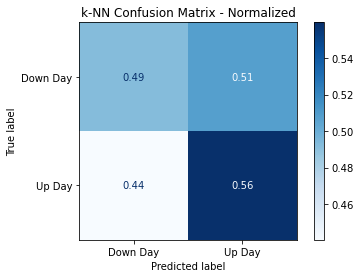

In [15]:
# Compute Confusion Matrix
knn_matrix = confusion_matrix(y_test, y_pred)

# Save individual values
true_negatives = knn_matrix[0][0] 
false_negatives = knn_matrix[1][0] 
true_positives = knn_matrix[1][1] 
false_positives = knn_matrix[0][1]

# Compute performance values
accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives) 
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

# Print values
print('Accuracy: {}'.format(float(accuracy))) 
print('Percision: {}'.format(float(percision))) 
print('Recall: {}'.format(float(recall))) 
print('Specificity: {}'.format(float(specificity)))

# Visualise the Confusion Matrix
disp = plot_confusion_matrix(best_knn, X_test, y_test, display_labels = ['Down Day', 'Up Day']
                             , normalize = 'true', cmap=plt.cm.Blues) 
disp.ax_.set_title('k-NN Confusion Matrix - Normalized')
plt.show()

### With the information from the confusion matrix we want know now how the proportion is. 
#### How is the prediction distributed, and how ist the real values distributed

In [16]:
# Propotion of the real values
unique, counts = np.unique(y_test, return_counts=True)
print('Real Proportion')
print(dict(zip(unique, counts/len(y_test))))
print()

# Propotion of the predicted values
unique, counts = np.unique(y_pred, return_counts=True)
print('Predicted Proportion')
print(dict(zip(unique, counts/len(y_pred))))

Real Proportion
{0: 0.448559670781893, 1: 0.551440329218107}

Predicted Proportion
{0: 0.46364883401920437, 1: 0.5363511659807956}


#### We see that the model over predict the Up days and under predict the Down days.

# ----------------------------------------------------------------------------------------

## Feature Importance

([<matplotlib.patches.Wedge at 0x7fa2e183d820>,
 [Text(0.709384411221588, 0.8406983746361124, 'RSI'),
  Text(-0.9663717942967067, 0.5254765029834959, 'K_percent'),
  Text(-0.6241262456239358, -0.9057960198208926, 'ROC'),
  Text(0.7614909253094666, -0.7938082707249482, 'MACD')],
 [Text(0.45142644350464683, 0.5349898747684351, '27.7%'),
  Text(-0.6149638690979041, 0.33439413826222464, '28.8%'),
  Text(-0.3971712472152318, -0.5764156489769315, '17.9%'),
  Text(0.48458513428784233, -0.5051507177340578, '25.7%')])

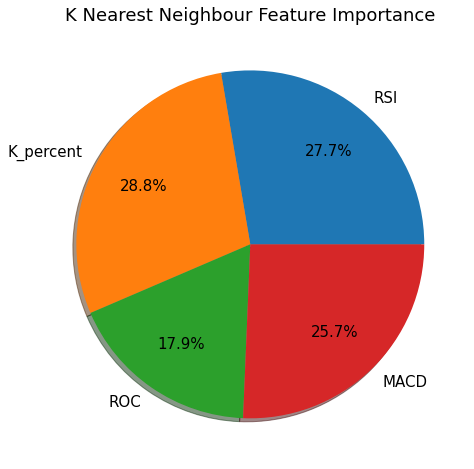

In [17]:
# perform permutation importance
results = permutation_importance(best_knn, X_train, y_train)

# get importance for accuracy
importance = results.importances_mean

# Create Pie Plot
imp_scale = sum(importance)
imp = importance/imp_scale
def func(pct, allvalues):
    return "{:.1f}%".format(pct)

plt.figure(figsize=(8,8))
plt.title('K Nearest Neighbour Feature Importance', fontsize = 18)
plt.pie(imp, labels=['RSI','K_percent','ROC','MACD'], autopct = lambda pct: func(pct, imp), 
        shadow=True, pctdistance=.7, textprops={'fontsize': 15})

# ----------------------------------------------------------------------------------------

# ROC Curve
##### The Receiver Operating Characteristic is a graphical method to evaluate the performance of a binary classifier. A curve is drawn by plotting True Positive Rate (sensitivity) against False Positive Rate (1 - specificity) at various threshold values. ROC curve shows the trade-off between sensitivity and specificity. When the curve comes closer to the left-hand border and the top border of the ROC space, it indicates that the test is accurate. The closer the curve is to the top and left-hand border, the more accurate the test is. If the curve is close to the 45 degrees diagonal of the ROC space, it means that the test is not accurate. ROC curves can be used to select the optimal model and discard the suboptimal ones.

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


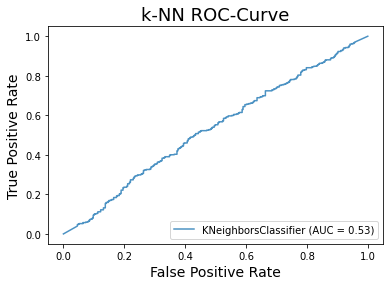

In [18]:
# Create an ROC Curve plot.
knn_disp = plot_roc_curve(best_knn, X_test, y_test, alpha = 0.8)
plt.title('k-NN ROC-Curve', fontsize=18)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.show()

#### How we can see the ROC curve is not very good and also the confusion matrix shows us that we only can trust the model result if the model predict a Signal = 1. 

# ----------------------------------------------------------------------------------------

# Trading Performance

In [19]:
n = len(y_pred)

In [20]:
X = bco['Log_Returns'].shift(-1) 
X = X[len(X)-n:]
len(X)

729

## Long

In [21]:
perf = y_pred * X
perf = perf.dropna()

trading_days_Y = 5*52 

perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))

## Long-Short

In [22]:
# Transform 0,1 Signal in a -1,1 Signal
y_pred1 = []
for i in range(0,len(y_pred)):
    if y_pred[i] == 0:
        y_pred1.append(-1)
    else:
        y_pred1.append(1)

In [23]:
perf1 = y_pred1 * X
perf1 = perf1.dropna()

trading_days_Y = 5*52 

perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))

## Buy and Hold 

In [24]:
perf2 = X
perf2 = perf2.dropna()

trading_days_Y = 5*52 

perf_sharpe2 = np.sqrt(trading_days_Y) * np.mean(perf2) / (np.sqrt(np.var(perf2)))

# Comparison ML vs. Buy and Hold

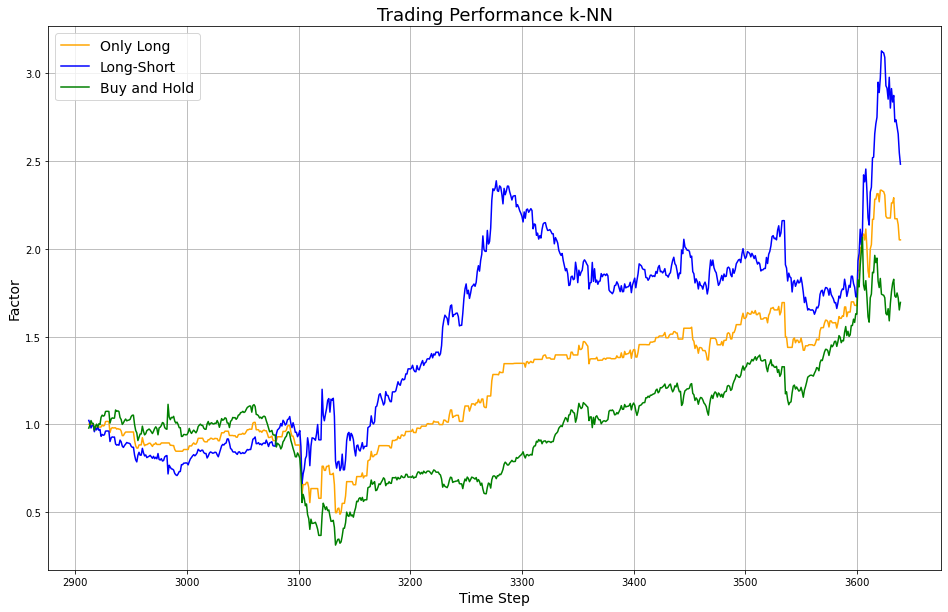

In [25]:
plt.figure(figsize=(16,10))
plt.title('Trading Performance k-NN', fontsize = 18)
plt.ylabel('Factor', fontsize = 14)
plt.xlabel('Time Step', fontsize = 14)
plt.grid(True)
plt.plot(np.exp(perf).cumprod() , label='Only Long', color = 'orange')
plt.plot(np.exp(perf1).cumprod() , label='Long-Short', color = 'blue')
plt.plot(np.exp(perf2).cumprod() , label='Buy and Hold', color = 'green')
plt.legend(loc='best', fontsize = 14)

# Profit Factor

In [26]:
L_profit = np.exp(perf).cumprod().iloc[-1]

LS_profit = np.exp(perf1).cumprod().iloc[-1]

BaH_profit = np.exp(perf2).cumprod().iloc[-1]

# Performance Table

In [27]:
#create data
data = [["Buy and Hold", round(perf_sharpe2,2), round(BaH_profit,2)], 
        ["Only Long", round(perf_sharpe,2), round(L_profit,2)], 
        ["Long Short", round(perf_sharpe1,2), round(LS_profit,2)]]
  
#define header names
col_names = ["Strategie", "Sharp Ratio", "Profit Factor"]
  
#display table
print('k-NN Classification')
print(tabulate(data, headers=col_names))

k-NN Classification
Strategie       Sharp Ratio    Profit Factor
------------  -------------  ---------------
Buy and Hold           0.35             1.69
Only Long              0.57             2.05
Long Short             0.6              2.48


In [28]:
# Performance Dataset
BaH_Perf = np.exp(perf2).cumprod()
knn_Perf_OL = np.exp(perf).cumprod()
knn_Perf_LS = np.exp(perf1).cumprod()

knn_Perf_data = pd.DataFrame()
knn_Perf_data['BaH_Perf'] = BaH_Perf
knn_Perf_data['knn_Perf_OL'] = knn_Perf_OL
knn_Perf_data['knn_Perf_LS'] = knn_Perf_LS

knn_Perf_data.to_csv('/Users/romaindeleze/Desktop/BSc/Romain_WI_TZ/8.Semester/BA/Daten/knn_Perf_data')

# Extrem and Regular Value Accuracy

In [41]:
# Creat Data Frame with Predicted Signal and Log Returns
n = len(y_pred)
X = bco['Log_Returns'].shift(-1)
X = X[len(X)-n:]
d = {'Predicted Signal':y_pred, 'Log Returns':X}
df = pd.DataFrame(data = d)
#print(df)

# Creat the upperbound and the lowerbound
μ = np.mean(X)
σ = np.std(X)
lb = μ-2*σ
ub = μ+2*σ

# Creat Data Frame with only Values in the interval [lb,ub]
reg_val = df[(df['Log Returns'] >= lb) & (df['Log Returns'] <= ub)] # DataFrame with Regular Values = [lb,ub]
#print(len(reg_val))

# Creat Data Frame with only Values outside the interval [lb,ub]
ext_val = df.drop(index=reg_val.index)
#print(len(ext_val))

# Add real Signal with the Log Returns for each Data Frame
reg_val['Real Signal'] = (reg_val['Log Returns'] > 0).astype(int)
ext_val['Real Signal'] = (ext_val['Log Returns'] > 0).astype(int)
#print(reg_val)
#print(ext_val)

# Compute accuracy of the Extrem Values and the Regular Values
acc_reg = accuracy_score(reg_val['Real Signal'], reg_val['Predicted Signal'], normalize = True) * 100.0
acc_ext = accuracy_score(ext_val['Real Signal'], ext_val['Predicted Signal'], normalize = True) * 100.0
print('Accuracy Regular Values = ', round(acc_reg,2))
print('Accuracy Exrtem Values = ', round(acc_ext,2))

Accuracy Regular Values =  52.53
Accuracy Exrtem Values =  58.33


<ipython-input-41-af20464ad81b>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reg_val['Real Signal'] = (reg_val['Log Returns'] > 0).astype(int)


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Density Plot of Brent Crude Oil Future Log Returns'}, xlabel='Log_Returns', ylabel='Density'>

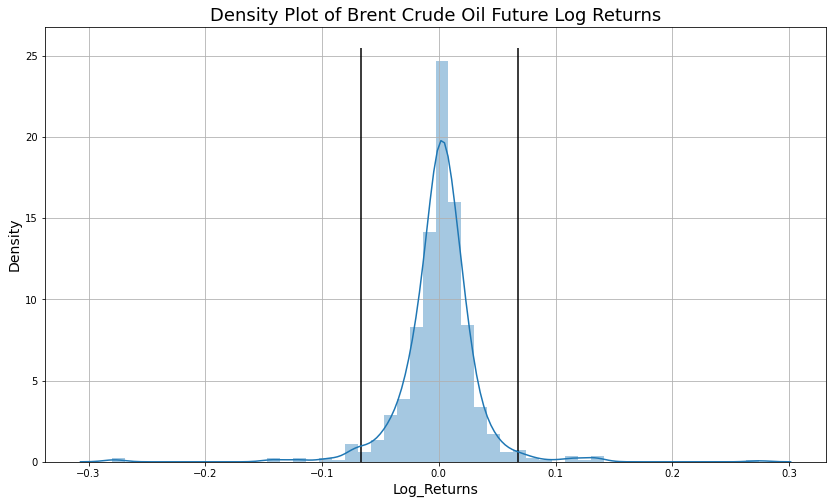

In [42]:
plt.figure(figsize=(14,8))
plt.title('Density Plot of Brent Crude Oil Future Log Returns', fontsize = 18)
plt.ylabel('Density', fontsize = 14)
plt.xlabel('Log Returns', fontsize = 14)
plt.grid(True)
plt.vlines(x=lb, ymin=0,ymax=25.5, color = 'black')
plt.vlines(x=ub, ymin=0,ymax=25.5, color = 'black')
sns.distplot(X)

[*********************100%***********************]  1 of 1 completed


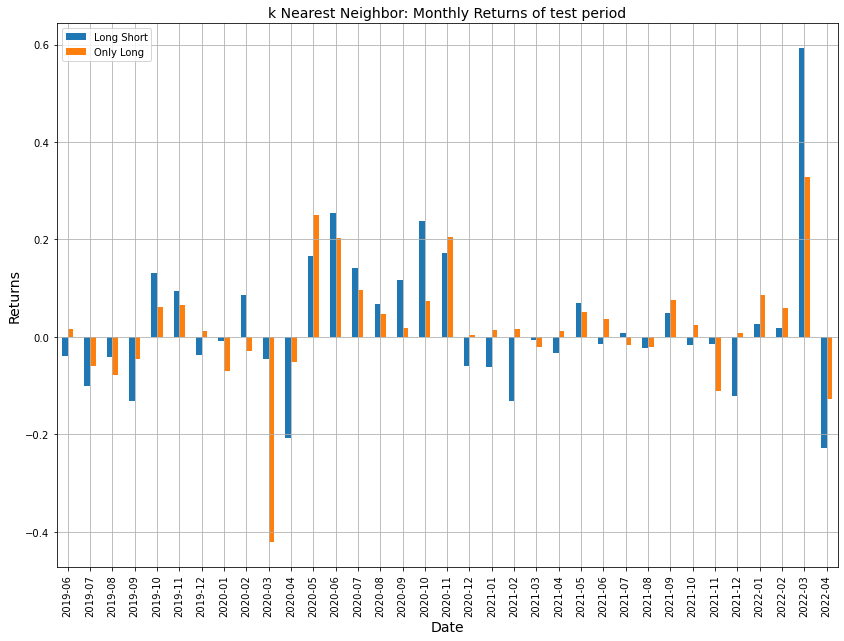

In [46]:
#Indexing
dat = yf.download('BZ=F', start='2007-08-16',end = "2022-04-26",period='1d')
end_len = len(dat["Close"])
long_short = np.exp(perf1).cumprod()
start_len = end_len - len(long_short)
index = dat["Close"][start_len:end_len].index
perf1.index = index
perf.index = index




#Create Monthly Returns Long Short
da = perf1.groupby([(perf1.index.year),(perf1.index.month)]).sum()


monthly_ret_LS = da.values
n = len(monthly_ret_LS)
monthly_ret_LS = pd.DataFrame(monthly_ret_LS,index = pd.date_range(start='6/1/2019', freq='M', periods=n))



#Create Monthly Returns Long
da1 = perf.groupby([(perf.index.year),(perf.index.month)]).sum()
monthly_ret_OL = da1.values
monthly_ret_OL = pd.DataFrame(monthly_ret_OL,index = pd.date_range(start='6/1/2019', freq='M', periods=n))



#Connect DF
mon_ret = pd.concat([monthly_ret_LS, monthly_ret_OL], axis=1)
mon_ret.columns = ["Long Short","Only Long"]



#x Axis
x_ax = pd.period_range('6/1/2019', '2022-04-30', freq='M').strftime('%Y-%m')
mon_ret.index = x_ax




#Plot the barplot



ax = mon_ret.plot.bar(figsize=(14,10), rot = 0)
plt.title("k Nearest Neighbor: Monthly Returns of test period",fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(rotation=90)
plt.ylabel('Returns', fontsize=14)
plt.legend(loc='best')
plt.grid()

# ----------------------------------------------------------------------------------------

# Time Series Cross Validation Backwards

In [29]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#                     |                    |                    |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#                     |                    |       Train        |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#                     |        Train       |       Train        |       Train        |          Test         |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#       Train          |        Train       |       Train        |       Train        |          Test        |
#------------------------------------------------------------------------------------------------------------#

L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []

for k in range (1,5):

    X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.2, shuffle=False)
    
    for i in range(1,2):
        feature_len = int(round(len(X_train))*0.25*k)
        X_train = X_train[-feature_len:]
        label_len = int(round(len(y_train))*0.25*k)
        y_train = y_train[-label_len:]
    

        knn_random.fit(X_train, y_train)
        param = knn_random.best_params_
        best_knn = KNeighborsClassifier(weights = param['weights'], 
                                        p = param['p'], 
                                        n_neighbors = param['n_neighbors'], 
                                        leaf_size = param['leaf_size'], 
                                        algorithm = param['algorithm'])
    
        # Fit the data to the model
        best_knn.fit(X_train, y_train) 

        # Make predictions
        y_pred = best_knn.predict(X_test)
        
        # Trading Performance
        n = len(y_pred)
        X = bco['Log_Returns'].shift(-1)
        X = X[len(X)-n:]
        
        trading_days_Y = 5*52
        
        # Only Long
        perf = y_pred * X
        perf = perf.dropna()
        # Sharpe
        perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
        L_Sharpe_Ratios.append(perf_sharpe)
        
        # Long Short
        # Transform 0,1 Signal in a -1,1 Signal
        y_pred1 = []
        for i in range(0,len(y_pred)):
            if y_pred[i] == 0:
                y_pred1.append(-1)
            else:
                y_pred1.append(1)
                    
        perf1 = y_pred1 * X
        perf1 = perf1.dropna()
        # Sharpe
        perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
        LS_Sharpe_Ratios.append(perf_sharpe1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [30]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4"]
  
#display table
print('k Nearest Neighbour')
print('Cross Validation Time Series Split Backward')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

k Nearest Neighbour
Cross Validation Time Series Split Backward
Sharpe Ratio
              K = 1    K = 2    K = 3    K = 4
----------  -------  -------  -------  -------
Only Long      1.1     -0.33     0.65     0.57
Long Short     1.13    -0.79     0.46     0.6


In [31]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))

Mean Only Long Sharpe Ratio =  0.5
Mean Long Short Sharpe Ratio =  0.35


# ----------------------------------------------------------------------------------------

# Time Series Cross Validation Forwards

In [32]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Test         |                    |                    |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Test          |                    |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Train         |        Test        |                       |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train        |      Train         |        Train       |       Test            |
#------------------------------------------------------------------------------------------------------------#


L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []

for k in range (2,6):
    
    feature_len = int(round(len(features))*0.2*k)
    label_len = int(round(len(labels))*0.2*k)
    
    features1 = features[:feature_len]
    labels1 = labels[:label_len]

    X_train = features1[:-729]
    X_test = features1[-729:]
    y_train = labels1[:-729]
    y_test = labels1[-729:]
    

    for i in range(1,2):
        knn_random.fit(X_train, y_train)
        param = knn_random.best_params_
        best_knn = KNeighborsClassifier(weights = param['weights'], 
                                        p = param['p'], 
                                        n_neighbors = param['n_neighbors'], 
                                        leaf_size = param['leaf_size'], 
                                        algorithm = param['algorithm'])
    
        # Fit the data to the model
        best_knn.fit(X_train, y_train) 

        # Make predictions
        y_pred = best_knn.predict(X_test)
        
        # Trading Performance
        X = bco['Log_Returns'].shift(-1)
        X = X[:label_len]
        X = X[-729:]
        
        trading_days_Y = 5*52
        
        # Only Long
        perf = y_pred * X
        perf = perf.dropna()
        # Sharpe
        perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
        L_Sharpe_Ratios.append(perf_sharpe)
        
        # Long Short
        # Transform 0,1 Signal in a -1,1 Signal
        y_pred1 = []
        for i in range(0,len(y_pred)):
            if y_pred[i] == 0:
                y_pred1.append(-1)
            else:
                y_pred1.append(1)
                    
        perf1 = y_pred1 * X
        perf1 = perf1.dropna()
        # Sharpe
        perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
        LS_Sharpe_Ratios.append(perf_sharpe1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [33]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4"]
  
#display table
print('k Nearest Neigbour')
print('Cross Validation Time Series Split Forward')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

k Nearest Neigbour
Cross Validation Time Series Split Forward
Sharpe Ratio
              K = 1    K = 2    K = 3    K = 4
----------  -------  -------  -------  -------
Only Long      0.48     0.01     0.7      0.57
Long Short     0.25     0.79     0.62     0.6


In [34]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))

Mean Only Long Sharpe Ratio =  0.44
Mean Long Short Sharpe Ratio =  0.56


# ----------------------------------------------------------------------------------------

# K-Fold Cross Validation

In [35]:
#------------------------------------------------------------------------------------------------------------#
#                                               Full Dataset                                                 |
#------------------------------------------------------------------------------------------------------------#
# t_0 <--------------------------------------------------------------------------------------------------> t_n


# K = 1
#------------------------------------------------------------------------------------------------------------#
#        Test         |       Train         |       Train       |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 2
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Test          |       Train       |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 3
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Test        |       Train        |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 4
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Train       |       Test         |         Train         |
#------------------------------------------------------------------------------------------------------------#

# K = 5
#------------------------------------------------------------------------------------------------------------#
#        Train        |       Train         |       Train       |       Train        |         Test          |
#------------------------------------------------------------------------------------------------------------#

L_Sharpe_Ratios = []
LS_Sharpe_Ratios = []
Acc_score = []

for k in range (1,6):
    # Choose of the features we want in the Random Forest model
    
    L1 = int(round(len(features))*0.20*k)+1 # Geben
    L2 = int(round(len(features))*0.20*(k-1)) # Entfernen
    
    X_test = features[L2:L1]
    X_train = features.drop(index=X_test.index)
    
    y_test = labels[L2:L1]
    y_train = labels.drop(index=y_test.index)
    

    for i in range(1,2):
        knn_random.fit(X_train, y_train)
        param = knn_random.best_params_
        best_knn = KNeighborsClassifier(weights = param['weights'], 
                                        p = param['p'], 
                                        n_neighbors = param['n_neighbors'], 
                                        leaf_size = param['leaf_size'], 
                                        algorithm = param['algorithm'])
    
        # Fit the data to the model
        best_knn.fit(X_train, y_train) 

        # Make predictions
        y_pred = best_knn.predict(X_test)
        Acc_score.append(accuracy_score(y_test, y_pred, normalize = True) * 100.0)
        
        # Trading Performance
        X = bco['Log_Returns'].shift(-1)
        X = X[L2:L1]
        
        trading_days_Y = 5*52
        
        # Only Long
        perf = y_pred * X
        perf = perf.dropna()
        # Sharpe
        perf_sharpe = np.sqrt(trading_days_Y) * np.mean(perf) / (np.sqrt(np.var(perf)))
        L_Sharpe_Ratios.append(perf_sharpe)
        
        # Long Short
        # Transform 0,1 Signal in a -1,1 Signal
        y_pred1 = []
        for i in range(0,len(y_pred)):
            if y_pred[i] == 0:
                y_pred1.append(-1)
            else:
                y_pred1.append(1)
                    
        perf1 = y_pred1 * X
        perf1 = perf1.dropna()
        # Sharpe
        perf_sharpe1 = np.sqrt(trading_days_Y) * np.mean(perf1) / (np.sqrt(np.var(perf1)))
        LS_Sharpe_Ratios.append(perf_sharpe1)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [36]:
# create data
data = [["Only Long", round(L_Sharpe_Ratios[0],2), round(L_Sharpe_Ratios[1],2),
         round(L_Sharpe_Ratios[2],2), round(L_Sharpe_Ratios[3],2), round(L_Sharpe_Ratios[4],2)], 
        ["Long Short", round(LS_Sharpe_Ratios[0],2), round(LS_Sharpe_Ratios[1],2),
         round(LS_Sharpe_Ratios[2],2), round(LS_Sharpe_Ratios[3],2), round(LS_Sharpe_Ratios[4],2)],
        ["Accuracy", round(Acc_score[0],2), round(Acc_score[1],2),
         round(Acc_score[2],2), round(Acc_score[3],2), round(Acc_score[4],2)]]
  
#define header names
col_names = ["K = 1", "K = 2", "K = 3", "K = 4", "K = 5"]
  
#display table
print('k Nearest Neighbour')
print('K-Fold Cross Validation')
print('Sharpe Ratio')
print(tabulate(data, headers=col_names))

k Nearest Neighbour
K-Fold Cross Validation
Sharpe Ratio
              K = 1    K = 2    K = 3    K = 4    K = 5
----------  -------  -------  -------  -------  -------
Only Long      1.59     0.65    -0.34     0.84     0.57
Long Short     2.01     0.51     0.33     0.99     0.6
Accuracy      53.36    52.54    50.75    51.99    52.95


In [37]:
print('Mean Only Long Sharpe Ratio = ',round(np.mean(L_Sharpe_Ratios),2))
print('Mean Long Short Sharpe Ratio = ',round(np.mean(LS_Sharpe_Ratios),2))
print('Mean Accuracy Score = ',round(np.mean(Acc_score),2))

Mean Only Long Sharpe Ratio =  0.66
Mean Long Short Sharpe Ratio =  0.89
Mean Accuracy Score =  52.32


In [38]:
round(np.std(Acc_score),2)

0.9